# Imports

In [ ]:
# pip install scipy

In [251]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import integrate
import time

# Model Parameters

In [253]:
# problem parameters
N = 100              # stages
iterationNumb = 1000 # iterations for MCS
C = 600             # Business ticket price
# Uniform parameters
a = 200
b = C
q = 2 ** (1/(N-1))

# Exact Method

We start by generating $N$ normaly ditributed variables $\omega_k\sim\mathcal{U}\left(a_k,b\right)$ with $a_k=a\cdot q^k$ and $q = 400^{1/(N-1)}$.

In [254]:
def uniformOmega(a, b, n, seed=1234):
    # We fix the seed to reproduce same results
    np.random.seed(seed)
    a_arr = np.array([a*q**(k) for k in range(N)])
    omega = np.array([])
    omega = np.array([np.round_(np.random.uniform(a_arr[k], b, 1), 2) for k in range(n)]).reshape((n,))
    
    return omega, a_arr

In [255]:
omega, a_arr = uniformOmega(a, b, N)
omega

array([276.61, 449.37, 376.68, 515.05, 513.24, 314.22, 316.79, 522.74,
       583.74, 551.99, 352.44, 408.39, 478.93, 490.56, 361.07, 434.2 ,
       413.01, 230.44, 515.23, 556.4 , 365.05, 458.34, 260.95, 369.59,
       575.7 , 473.89, 382.95, 524.28, 356.33, 446.69, 553.77, 401.8 ,
       530.8 , 302.02, 497.6 , 498.24, 332.31, 574.39, 410.86, 569.42,
       284.7 , 327.96, 284.08, 492.79, 467.1 , 447.89, 290.03, 458.75,
       385.42, 441.87, 319.21, 476.59, 464.5 , 291.96, 482.13, 573.1 ,
       536.32, 597.61, 587.65, 538.07, 388.73, 489.93, 447.98, 367.45,
       422.77, 330.6 , 445.08, 594.96, 356.42, 357.14, 528.49, 488.07,
       457.92, 361.98, 396.34, 573.8 , 448.65, 480.67, 346.89, 423.57,
       459.32, 504.06, 579.97, 509.28, 529.48, 398.21, 540.38, 560.75,
       515.89, 472.47, 409.81, 504.28, 496.62, 589.49, 488.92, 495.02,
       503.53, 562.83, 408.79, 533.88])

We compute our $\alpha_k$ to help compute the cost-to-go funtion as,
\begin{equation}
    \alpha_k = \left\{
            \begin{array}{ll}
                C & \text{if } k = N\\
                \mathbb{E}_{\omega_k}\left[\min\left\{\omega_k,\alpha_{k+1}\right\}\right] & \text{otherwise}.
            \end{array}
        \right.
\end{equation}

In [256]:
def computeAlpha(a, b, a_arr):
    alpha = np.zeros((N,), dtype=np.float64)
    alpha[-1] = C

    for k in range(N-1,0,-1):
        
        integrand = lambda x:  min(x, alpha[k]) / (b-a_arr[k])
        expected_min = integrate.quad(integrand, a_arr[k], b)[0]

        alpha[k-1] = np.round_(expected_min, 2)
    
    return alpha

In [257]:
alpha = computeAlpha(a, b, a_arr)
alpha

array([234.01, 235.46, 236.92, 238.39, 239.87, 241.36, 242.86, 244.37,
       245.89, 247.42, 248.96, 250.51, 252.07, 253.64, 255.22, 256.81,
       258.41, 260.02, 261.64, 263.27, 264.91, 266.56, 268.22, 269.89,
       271.57, 273.26, 274.96, 276.67, 278.4 , 280.14, 281.89, 283.65,
       285.42, 287.2 , 288.99, 290.79, 292.6 , 294.43, 296.27, 298.12,
       299.98, 301.85, 303.73, 305.63, 307.54, 309.46, 311.39, 313.33,
       315.29, 317.26, 319.24, 321.24, 323.25, 325.27, 327.31, 329.36,
       331.42, 333.5 , 335.59, 337.69, 339.81, 341.94, 344.09, 346.25,
       348.43, 350.63, 352.84, 355.07, 357.32, 359.59, 361.88, 364.19,
       366.52, 368.88, 371.26, 373.67, 376.11, 378.59, 381.11, 383.67,
       386.28, 388.95, 391.68, 394.49, 397.39, 400.39, 403.52, 406.8 ,
       410.27, 413.98, 417.99, 422.39, 427.31, 432.95, 439.62, 447.83,
       458.57, 473.95, 500.  , 600.  ])

#### Dynamic programming solution

We use backward chaining to compute the cost-to-go starting from $k=N$,
\begin{equation}
    {J}_{k}({x}_k) = \left\{
            \begin{array}{ll}
                C & \text{if } k = N\\
                \min\left\{\omega_{k},\alpha_k\right\} & \text{otherwise}.
            \end{array}
        \right.
\end{equation}

In [258]:
buyingPrice = np.zeros((iterationNumb,), dtype=np.float64)
exitTime = np.zeros((iterationNumb,), dtype=np.int64)
t = time.time()

for i in range(iterationNumb):
    
    # generate random variables omega
    omega, a_arr = uniformOmega(a, b, N, i**2) #i**2

    J = np.zeros((N+1,), dtype=np.float64)
    u = np.zeros((N+1,), dtype=np.int64)

    J[-1] = C
    u[-1] = 1

    # exit index
    exit = N
    # alpha = computeAlpha(a, b, a_arr)
    for k in reversed(range(0,N)):
        J[k] = min(omega[k], alpha[k])
        u[k] = (omega[k] <= alpha[k])

        # memorize exiting index
        if u[k] == 1:
            exit = k

    # setting u to zeo after first u = 1
    if exit < N:
        u[exit+1:] = 0
        
    buyingPrice[i] = np.dot(J, u)
    exitTime[i] = 1 + np.argmax(u)
    
print(f"exact method time: {time.time() -t}")

exact method time: 1.5487308502197266


In [219]:
print(f'Average time: {np.round_(np.mean(buyingPrice), 2)} $')

Average time: 232.54 $


In [220]:
# exitLap
unique, counts = np.unique(exitTime, return_counts=True)
counts
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 70, 72,
       76, 82, 84])

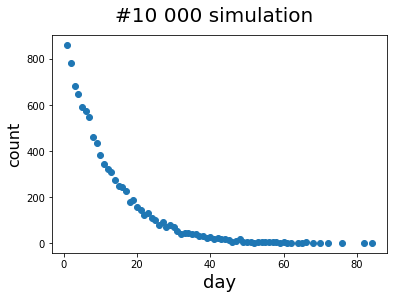

In [221]:
fig = plt.figure()
plt.plot(unique, counts, 'o')

fig.suptitle('#10 000 simulation', fontsize=20)
plt.xlabel('day', fontsize=18)
plt.ylabel('count', fontsize=16)
fig.savefig('plt3.jpg')

plt.show()

In [222]:
np.mean(exitTime)

11.2291

# Approximate Method

##### Q = 10            # number of samples
size = 100

In [223]:
Q = 10
l = 2
size = 100

In [260]:
t = time.time()
def linearArchitecture(N, Q, l=2):
    k = N-1
    r_hat = np.zeros((N+1,l+1))
    r_hat[-1] = [0 for i in range(l+1)]
    r_hat[-1, 0] = C
    while k >= 0:
        s = 1
        beta_k = np.zeros(Q)
        phi_k = np.zeros((Q, size, l+1))
        x_k_s = np.zeros(Q)
        phi_ks = np.zeros((Q, l+1))
        while s <= Q:
            if k == N-1:
                omega = np.round_(np.random.uniform(a_arr[k], b, size), 2)
            else:
                omega = np.round_(np.random.uniform(a_arr[k+1], b, size), 2)
            x_k_s[s-1] = np.round_(np.random.uniform(a_arr[k], b), 2)
            phi_ks[s-1] = np.array([x_k_s[s-1] ** i for i in range(l+1)])
            g_k_s = x_k_s[s-1]
            phi_k[s-1] = np.array([(omega ** i).tolist() for i in range(l+1)]).T
            beta_k[s-1] = np.mean(np.minimum(g_k_s, np.dot(phi_k[s-1], r_hat[k+1])), axis=0)
            s = s+1
        #print(f"k: {k}, x_s: {x_k_s}, beta_k: {beta_k}")
        r_k = np.dot(np.linalg.inv(np.dot(phi_ks.T, phi_ks)), np.dot(beta_k, phi_ks))
        r_hat[k] = r_k
        # print(f"k: {k}, r_hat: {r_k}")
        k = k-1
    return r_hat
print(f"parameter method time: {time.time() -t}")

parameter method time: 0.0003829002380371094


In [225]:
test = linearArchitecture(N, Q, l=1)

In [226]:
iterationNumb = 10000
N = 100
l = 1
u_iter = np.zeros(iterationNumb)
buying_price = np.zeros(iterationNumb)

t_online = np.zeros(iterationNumb)
t_offline = np.zeros(iterationNumb)

In [259]:
t = time.time()
for i in range(iterationNumb):  
    omega, a_arr = uniformOmega(a, b, N, i**2)
    u = np.zeros(N)
    k = 0
    J_arr = np.zeros(N)
    r_hat = linearArchitecture(N, Q, l)
    
    while k < N:
        J = np.dot(r_hat[k], np.array([omega[k] ** i for i in range(l+1)]))
        if omega[k] < J:
            u[k] = 1 # buy ticket
            J_arr[k] = min(omega[k], C)
            break
        k = k + 1
    
    # if we don't buy at all, then we buy at the last day
    if np.any(u) == 0:
        u[-1] = 1
        J_arr[-1] = omega[-1]
        
    u_iter[i] = np.argmax(u)+1
    buying_price[i] = np.sum(J_arr*u)

print(f"approximate method time: {time.time() -t}")

exact method time: 91.1372389793396


In [228]:
np.mean(u_iter)

12.1098

In [250]:
unique_approx, counts_approx = np.unique(u_iter, return_counts=True)
counts_approx
#unique_approx

array([810, 736, 634, 616, 571, 550, 528, 451, 429, 373, 320, 328, 310,
       259, 257, 246, 217, 187, 198, 159, 162, 133, 139, 124, 109,  75,
       109,  83,  95,  69,  65,  54,  58,  60,  42,  41,  37,  38,  27,
        28,  21,  31,  21,  15,  23,  11,  15,  28,   8,  15,   8,   4,
        10,   5,   5,  10,   4,   3,   3,   4,   4,   2,   1,   1,   1,
         2,   2,   1,   2,   1,   1,   1,   2,   1,   1,   1,   1,   2,
         1,   1])

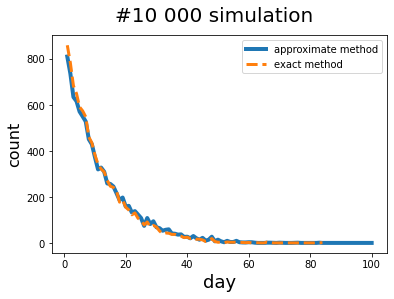

In [249]:
fig = plt.figure()
plt.plot(unique_approx, counts_approx, '-', linewidth=4, markersize=12)
plt.plot(unique, counts, '--', linewidth=3, markersize=12)

fig.suptitle('#10 000 simulation', fontsize=20)
plt.xlabel('day', fontsize=18)
plt.ylabel('count', fontsize=16)
fig.savefig('plt6.jpg')
plt.legend(['approximate method', 'exact method'])

plt.show()